# Sketchbook

## GPU acceleration of REBEL

In [1]:
import torch
torch.cuda.is_available()

True

In [2]:
with open("data/india_scraped_d0b1.txt", 'r') as f:

# with open("data/india_scraped.txt", 'r') as f:
    txt = f.read()

In [3]:
import json
print(json.dumps([txt]))

["TITLE: india\nIndia, officially the Republic of India, is a country in South Asia.  It is the seventh-largest country by area; the most populous country from June 2023 onwards; and since its independence in 1947, the world's most populous democracy. Bounded by the Indian Ocean on the south, the Arabian Sea on the southwest, and the Bay of Bengal on the southeast, it shares land borders with Pakistan to the west; China, Nepal, and Bhutan to the north; and Bangladesh and Myanmar to the east. In the Indian Ocean, India is near Sri Lanka and the Maldives; its Andaman and Nicobar Islands share a maritime border with Thailand, Myanmar, and Indonesia.\nModern humans arrived on the Indian subcontinent from Africa no later than 55,000 years ago. Their long occupation, predominantly in isolation as hunter-gatherers, has made the region highly diverse, second only to Africa in human genetic diversity. Settled life emerged on the subcontinent in the western margins of the Indus river basin 9,000

In [17]:
from rebel.rebel import extract_knowledge_graph

relations = extract_knowledge_graph(
    txt,
    64,
    10, 
    torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'),
    True,
    1
)

START: loading models
model device: cuda:0
DONE: loading models
START: tokenizing input
DONE: tokenizing input
START: knowledge graph extration


100%|██████████| 23/23 [00:26<00:00,  1.17s/it]

DONE: knowledge graph extration
START: make knowledge graph table
DONE: make knowledge graph table


In [18]:
len(relations)

475

In [19]:
import pandas as pd
df = pd.DataFrame(relations, columns=['head', 'relation', 'tail'])
df.index.name = 'id'
df.to_csv("data/india_kb.csv")

In [20]:
df

,head,relation,tail
id,,,
0,Karnataka,part of,North India
1,legislature of India,has part,lower house
2,Executive,part of,Government of India
3,early medieval age,end time,1200
4,Tamil literature,has part,Sangam literature
...,...,...,...
470,higher education,subclass of,education
471,1965 war with Pakistan,point in time,1965
472,Mahanadi,mouth of the watercourse,Bay of Bengal


In [21]:
relations

{('1891', 'point in time', '1891'),
 ('1921', 'point in time', '1921'),
 ('1947', 'point in time', '1947'),
 ('1947 partition', 'point in time', '1947'),
 ('1951', 'point in time', '1951'),
 ('1965', 'point in time', '1965'),
 ('1965 war', 'participant', 'Pakistan'),
 ('1965 war', 'point in time', '1965'),
 ('1965 war with Pakistan', 'point in time', '1965'),
 ('1971 war', 'point in time', '1971'),
 ('1981', 'point in time', '1981'),
 ('1991', 'point in time', '1991'),
 ('2001', 'point in time', '2001'),
 ('2001 Census', 'followed by', '2011 Census'),
 ('2004 Indian general elections', 'point in time', '2004'),
 ('2009 general election', 'point in time', '2009'),
 ('2011 Census', 'follows', '2001 Census'),
 ('2011 census', 'point in time', '2011'),
 ('2014 general election', 'successful candidate', 'Manmohan Singh'),
 ('2019 general election', 'office contested', 'prime minister of India'),
 ('ASEAN', 'has part', 'Japan'),
 ('ASEAN', 'has part', 'South Korea'),
 ('Achaemenid Empire',
 

## India_kb visualization

In [1]:
import pandas as pd
import networkx as nx 
import matplotlib.pyplot as plt
import numpy as np
from pyvis.network import Network

In [5]:
kb = pd.read_csv("data/india_kb_v2.csv")
kb

,head,relation,tail
0,Maharashtra,capital of,Mumbai
1,Mumbai,is capital of,Maharashtra
2,Karnataka,capital of,Bengaluru
3,Bengaluru,is capital of,Karnataka
4,Tamil Nadu,capital of,Chennai
...,...,...,...
491,Indian Postal Service,started during,British Rule
492,English Education,was introduced by,British
493,Indian Civil Service,was dominated by,British
494,Indian Army,was reorganized by,British


In [6]:
kb.to_numpy()

array([['Maharashtra', 'capital of', 'Mumbai'],
       ['Mumbai', 'is capital of', 'Maharashtra'],
       ['Karnataka', 'capital of', 'Bengaluru'],
       ...,
       ['Indian Civil Service', 'was dominated by', 'British'],
       ['Indian Army', 'was reorganized by', 'British'],
       ['Indian Police', 'was established by', 'British']],
      shape=(496, 3), dtype=object)

In [7]:
net = Network(directed=True)
for item in pd.concat([kb['head'], kb['tail']]).unique():
    net.add_node(item)
for head, rel, tail in kb.to_numpy():
    net.add_edge(head, tail, title=rel, label=rel)
net.repulsion(
    central_gravity=0.4, 
    spring_length=400,
    node_distance=200
)
net.set_edge_smooth('dynamic')
net.save_graph("demo_v2.html")


In [8]:
pd.concat([kb['head'], kb['tail']]).unique().shape

(344,)

In [11]:
G = nx.from_edgelist(zip(kb['head'], kb['tail']))

In [22]:
components = list(nx.connected_components(G))

Text(0.5, 1.0, 'Size of each connected component')

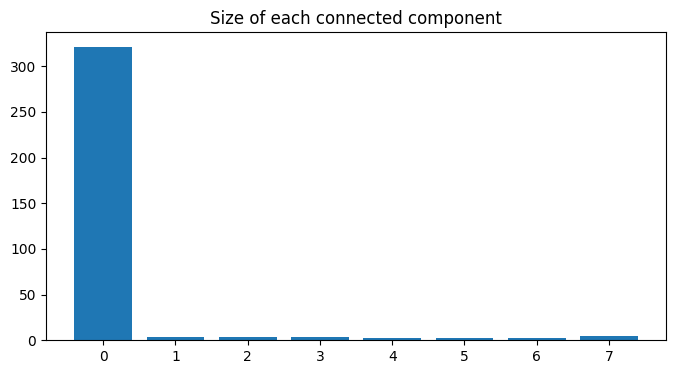

In [28]:
plt.figure(figsize=(8,4))
plt.bar(range(len(components)), list(map(len, components)))
plt.title("Size of each connected component")

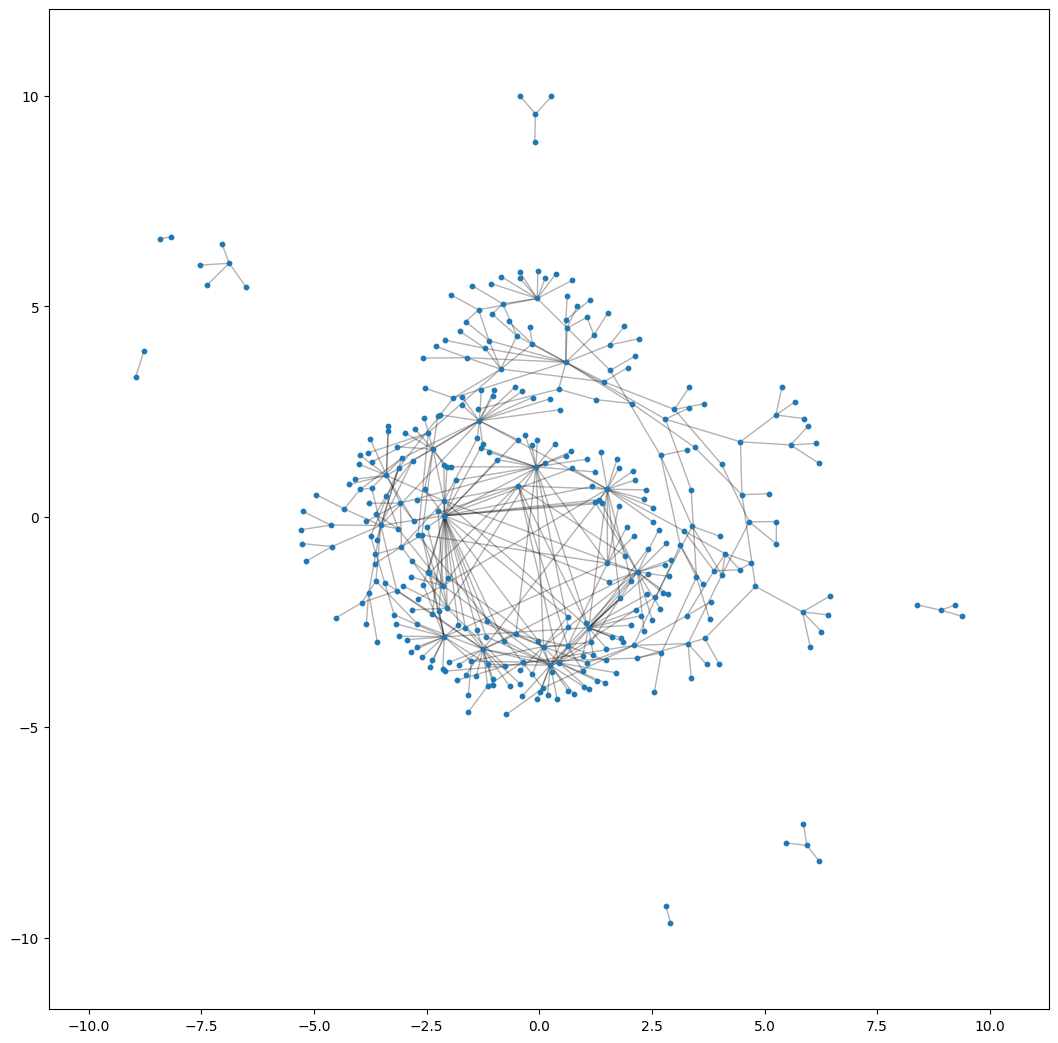

In [16]:
plt.figure(figsize=(10, 10))
k = 1/(len(G))**(0.5)
scale = 10
pos = nx.spring_layout(G, k=k, scale=scale)
pos = nx.spring_layout(G, k=k*20, pos=pos, iterations=1, scale=scale)
nx.draw(G, pos, node_size=10, edge_color=(0,0,0,0.3), hide_ticks=False)
# nx.draw_networkx_labels(G, pos, font_size=6, hide_ticks=False)
plt.axis("on")
None

In [17]:
with open("data/india_scraped.txt", 'r') as f:
    lines = f.readlines()

In [19]:
len("".join(lines).split())

4272328

In [21]:
len(lines)

128329

## Rebel code experiments

In [3]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
import torch
from tqdm import tqdm

def extract_triplets(text):
    triplets = []
    relation, subject, relation, object_ = '', '', '', ''
    text = text.strip()
    current = 'x'
    for token in text.replace("<s>", "").replace("<pad>", "").replace("</s>", "").split():
        if token == "<triplet>":
            current = 't'
            if relation != '':
                triplets.append({'head': subject.strip(), 'type': relation.strip(),'tail': object_.strip()})
                relation = ''
            subject = ''
        elif token == "<subj>":
            current = 's'
            if relation != '':
                triplets.append({'head': subject.strip(), 'type': relation.strip(),'tail': object_.strip()})
            object_ = ''
        elif token == "<obj>":
            current = 'o'
            relation = ''
        else:
            if current == 't':
                subject += ' ' + token
            elif current == 's':
                object_ += ' ' + token
            elif current == 'o':
                relation += ' ' + token
    if subject != '' and relation != '' and object_ != '':
        triplets.append({'head': subject.strip(), 'type': relation.strip(),'tail': object_.strip()})
    return triplets

In [4]:
tokenizer = AutoTokenizer.from_pretrained("Babelscape/rebel-large")
model = AutoModelForSeq2SeqLM.from_pretrained("Babelscape/rebel-large")

tokenizer_config.json:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/123 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/344 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

### Simple extration

In [3]:
text = 'Punta Cana is a resort town in the municipality of Higüey, in La Altagracia Province, the easternmost province of the Dominican Republic.'

In [8]:
input_tokens = tokenizer(text, return_tensors='pt')
input_tokens

{'input_ids': tensor([[    0,   510, 20339,  2615,   102,    16,    10,  5753,  1139,    11,
             5, 17300,     9, 19664,  2768,  2981,     6,    11,  1587,  7330,
          1073, 13249,   493, 16517,     6,     5,  4580,  7877,  2791,     9,
             5, 18978,  3497,     4,     2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [22]:
output_tokens = model.generate(
    **input_tokens
)
output_tokens

tensor([[    0, 50267,   221, 20339,  2615,   102,  1437, 50266,  1587,  7330,
          1073, 13249,   493, 16517,  1437, 50265,  2034,    11,     5,  6833,
         15752, 10014,  1437, 50266, 18978,  3497,  1437, 50265,   247,  1437,
         50267, 19664,  2768,  2981,  1437, 50266,  1587,  7330,  1073, 13249,
           493, 16517,  1437, 50265,  2034,    11,     5,  6833, 15752, 10014,
          1437, 50266, 18978,  3497,  1437, 50265,   247,  1437, 50267,  1587,
          7330,  1073, 13249,   493, 16517,  1437, 50266, 18978,  3497,  1437,
         50265,   247,  1437, 50267, 18978,  3497,  1437, 50266,  1587,  7330,
          1073, 13249,   493, 16517,  1437, 50265,  6308,  6833, 15752, 10014,
             2,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1]])

In [20]:
sentenses = tokenizer.batch_decode(output_tokens)
print(sentenses[0])

<s><triplet> Punta Cana <subj> La Altagracia Province <obj> located in the administrative territorial entity <subj> Dominican Republic <obj> country <triplet> Higüey <subj> La Altagracia Province <obj> located in the administrative territorial entity <subj> Dominican Republic <obj> country <triplet> La Altagracia Province <subj> Dominican Republic <obj> country <triplet> Dominican Republic <subj> La Altagracia Province <obj> contains administrative territorial entity</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>


In [21]:
extract_triplets(sentenses[0])

[{'head': 'Punta Cana',
  'type': 'located in the administrative territorial entity',
  'tail': 'La Altagracia Province'},
 {'head': 'Punta Cana', 'type': 'country', 'tail': 'Dominican Republic'},
 {'head': 'Higüey',
  'type': 'located in the administrative territorial entity',
  'tail': 'La Altagracia Province'},
 {'head': 'Higüey', 'type': 'country', 'tail': 'Dominican Republic'},
 {'head': 'La Altagracia Province',
  'type': 'country',
  'tail': 'Dominican Republic'},
 {'head': 'Dominican Republic',
  'type': 'contains administrative territorial entity',
  'tail': 'La Altagracia Province'}]

### Larger extration

In [3]:
with open("data/india_scraped.txt", 'r') as f:
    txt = f.read()

In [4]:
len(txt)

27385096

In [5]:
tokens = tokenizer(txt, return_tensors='pt')

Token indices sequence length is longer than the specified maximum sequence length for this model (6041115 > 1024). Running this sequence through the model will result in indexing errors


In [6]:
tokens['input_ids'].shape

torch.Size([1, 6041115])

In [7]:
tokens['attention_mask'].shape

torch.Size([1, 6041115])

In [ ]:
span_length = 128
input_ids = tokens['input_ids']
input_ids.shape

torch.Size([1, 6041115])

In [14]:
input_ids.squeeze().shape[0]

6041115

In [12]:
num_spans = input_ids.shape[1]//span_length
reshaped_input_ids = input_ids[:, :num_spans*span_length].reshape(num_spans, span_length)
reshaped_input_ids.shape

torch.Size([23598, 256])

In [31]:
batch_size = 5
num_batches = reshaped_input_ids.shape[0]//batch_size
batched_inputs = reshaped_input_ids[:batch_size*num_batches, :].reshape(num_batches, batch_size, span_length)
batched_inputs.shape

torch.Size([4719, 5, 256])

In [80]:
model.device

device(type='cpu')

In [63]:
def infer_batch(batch):
    output_tokens = model.generate(
        input_ids = batch,
        attention_mask = torch.ones_like(batch)
    )
    sentenses = tokenizer.batch_decode(output_tokens)
    return sentenses


In [ ]:
relations = []
for batch in tqdm(batched_inputs):
    sentenses = infer_batch(batch)
    for sentense in sentenses:
        triplets = extract_triplets(sentense)
        relations.extend(triplets)

In [65]:
len(relations)

144

In [66]:
relations

[{'head': 'Indian Plate',
  'type': 'shares border with',
  'tail': 'Indo-Australian Plate'},
 {'head': 'Indian tectonic plate',
  'type': 'shares border with',
  'tail': 'Indo-Australian Plate'},
 {'head': 'Indo-Australian Plate',
  'type': 'shares border with',
  'tail': 'Indian Plate'},
 {'head': 'Indo-Australian Plate',
  'type': 'shares border with',
  'tail': 'Indian tectonic plate'},
 {'head': 'Chota Nagpur Plateau',
  'type': 'located in the administrative territorial entity',
  'tail': 'Jharkhand'},
 {'head': 'Ganges', 'type': 'tributary', 'tail': 'Yamuna'},
 {'head': 'Ganges', 'type': 'tributary', 'tail': 'Kosi'},
 {'head': 'Yamuna', 'type': 'mouth of the watercourse', 'tail': 'Ganges'},
 {'head': 'Kosi', 'type': 'mouth of the watercourse', 'tail': 'Ganges'},
 {'head': 'India',
  'type': 'contains administrative territorial entity',
  'tail': 'Lakshadweep'},
 {'head': 'India',
  'type': 'contains administrative territorial entity',
  'tail': 'Andaman and Nicobar Islands'},
 {

In [ ]:
def extract_knowledge_graph(
    text: str,
    span_length: int,
    batch_size: int,
    prog_bar: bool = False
):
    print("START: loading models")
    tokenizer = AutoTokenizer.from_pretrained("Babelscape/rebel-large")
    model = AutoModelForSeq2SeqLM.from_pretrained("Babelscape/rebel-large")
    print("DONE: loading models")
    print("START: tokenizing input")
    tokens = tokenizer(text, return_tensors='pt')
    print("DONE: tokenizing input")
    input_ids = tokens['input_ids'].squeeze()
    input_ids
    num_spans = input_ids.shape[0]//span_length
    reshaped_input_ids = input_ids[:num_spans*span_length].reshape(num_spans, span_length)
    num_batches = reshaped_input_ids.shape[0]//batch_size
    batched_inputs = reshaped_input_ids[:num_batches*batch_size, :span_length].reshape(num_batches, batch_size, span_length)
    iterator = tqdm if prog_bar else iter
    print("START: knowledge graph extration")
    relations = []
    try:
        for batch in iterator(batched_inputs):
            sentenses = infer_batch(batch)
            for sentense in sentenses:
                triplets = extract_triplets(sentense)
                relations.extend(triplets)
        print("DONE: knowledge graph extration")
    except KeyboardInterrupt:
        print("INTERUPTED: knowledge graph extration")
        pass
    return relations
    

In [70]:
len(txt)

27385096

In [71]:
relations = extract_knowledge_graph(
    txt[:10000],
    128,
    5,
    True
)

START: tokenizing input
DONE: tokenizing input
START: knowledge graph extration


100%|██████████| 3/3 [00:49<00:00, 16.62s/it]

DONE: knowledge graph extration


In [72]:
len(relations)

43

In [74]:
len(txt[:10000].split())

1521

In [77]:
(43/1521) * 27385096

774200.6101249178

In [73]:
relations

[{'head': 'India',
  'type': 'located in or next to body of water',
  'tail': 'Indian Ocean'},
 {'head': 'India',
  'type': 'located in or next to body of water',
  'tail': 'Arabian Sea'},
 {'head': 'India',
  'type': 'located in or next to body of water',
  'tail': 'Bay of Bengal'},
 {'head': 'India', 'type': 'shares border with', 'tail': 'Pakistan'},
 {'head': 'India', 'type': 'shares border with', 'tail': 'China'},
 {'head': 'India', 'type': 'shares border with', 'tail': 'Nepal'},
 {'head': 'India', 'type': 'shares border with', 'tail': 'Bhutan'},
 {'head': 'India', 'type': 'shares border with', 'tail': 'Bangladesh'},
 {'head': 'India', 'type': 'shares border with', 'tail': 'Myanmar'},
 {'head': 'India',
  'type': 'located in or next to body of water',
  'tail': 'Indian Ocean'},
 {'head': 'India',
  'type': 'located in or next to body of water',
  'tail': 'Arabian Sea'},
 {'head': 'Thailand', 'type': 'shares border with', 'tail': 'Myanmar'},
 {'head': 'Thailand', 'type': 'shares bor

## Simple Demo

In [1]:
from rebel.rebel import make_kb

text = 'Punta Cana is a resort town in the municipality of Higüey, in La Altagracia Province, the easternmost province of the Dominican Republic.'

kb = make_kb(text)

In [3]:
import pandas as pd

pd.DataFrame(kb, columns=['head', 'relation', 'tail'])

,head,relation,tail
0,La Altagracia Province,instance of,province
1,Higüey,located in the administrative territorial entity,La Altagracia Province
2,Dominican Republic,contains administrative territorial entity,La Altagracia Province
3,Higüey,country,Dominican Republic
4,Punta Cana,located in the administrative territorial entity,La Altagracia Province
5,La Altagracia Province,country,Dominican Republic
6,province,country,Dominican Republic
7,Punta Cana,country,Dominican Republic


In [2]:
from rebel.rebel import make_kb
import pandas as pd
text = "Napoleon Bonaparte (born Napoleone di Buonaparte; 15 August 1769 – 5 " \
"May 1821), and later known by his regnal name Napoleon I, was a French military " \
"and political leader who rose to prominence during the French Revolution and led " \
"several successful campaigns during the Revolutionary Wars. He was the de facto " \
"leader of the French Republic as First Consul from 1799 to 1804. As Napoleon I, " \
"he was Emperor of the French from 1804 until 1814 and again in 1815. Napoleon's " \
"political and cultural legacy has endured, and he has been one of the most " \
"celebrated and controversial leaders in world history."

In [3]:
print(text)

Napoleon Bonaparte (born Napoleone di Buonaparte; 15 August 1769 – 5 May 1821), and later known by his regnal name Napoleon I, was a French military and political leader who rose to prominence during the French Revolution and led several successful campaigns during the Revolutionary Wars. He was the de facto leader of the French Republic as First Consul from 1799 to 1804. As Napoleon I, he was Emperor of the French from 1804 until 1814 and again in 1815. Napoleon's political and cultural legacy has endured, and he has been one of the most celebrated and controversial leaders in world history.


In [5]:
df = pd.DataFrame(make_kb(text, max_length=1024, num_beams=5, num_return_sequences=5), columns=['head', 'relation', 'tail'])

{'max_length': 1024, 'length_penalty': 0, 'num_beams': 5, 'num_return_sequences': 5}


In [7]:
df

,head,relation,tail
0,Revolutionary Wars,participant,Napoleon Bonaparte
1,Napoleon Bonaparte,participant in,French Revolution
2,Napoleon Bonaparte,conflict,Revolutionary Wars
3,French Revolution,participant,Napoleon Bonaparte
4,Napoleon Bonaparte,date of birth,15 August 1769
5,Revolutionary Wars,part of,French Revolution
6,Napoleon Bonaparte,date of death,5 May 1821
